# Analyzing GRB 080916C
To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

In [2]:
# Scientific libraries
import numpy as np


import matplotlib.pyplot as plt
from jupyterthemes import jtplot

%matplotlib inline
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
plt.style.use("mike")

from threeML import *

import warnings


warnings.simplefilter("ignore")

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [3]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [4]:
grb_info =  gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info['detectors']
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model =  gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [5]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                 value min_value max_value            unit
GRB080916009...K             0.0122548         0      None  keV-1 s-1 cm-2
GRB080916009...alpha          -1.13042      -1.5         2                
GRB080916009...break_energy    309.203        10      None             keV
GRB080916009...break_scale         0.3         0        10                
GRB080916009...beta           -2.09693        -5      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database. 



In [6]:
dload = download_GBM_trigger_data("bn080916009",detectors=gbm_detectors)

Let's first examine the catalof fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background. 
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Auto-determined polynomial order: 0




Binned 0-order polynomial fit with the Powell method



Saved fitted background to n3_bkg.h5.

Successfully restored fit from n3_bkg.h5
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 9-900 translates to channels 5-124
Now using 120 channels out of 128
Now using 120 bins


Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method



Saved fitted background to n4_bkg.h5.

Successfully restored fit from n4_bkg.h5
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 9-900 translates to channels 5-123
Now using 119 channels out of 128
Now using 119 bins


Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method



Saved fitted background to b0_bkg.h5.

Successfully restored fit from b0_bkg.h5
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 250-30000 translates to channels 1-119
Now using 119 channels out of 128
Now using 119 bins


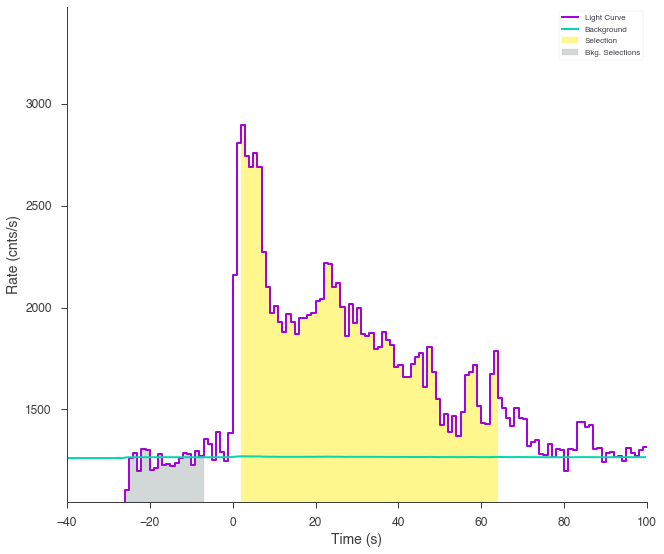

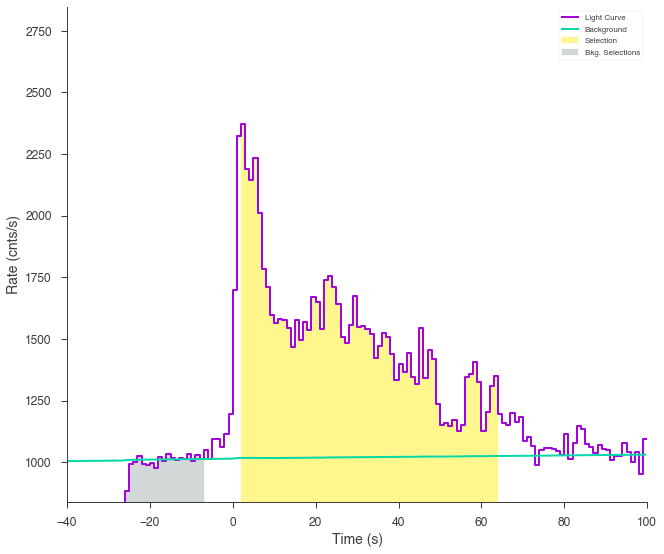

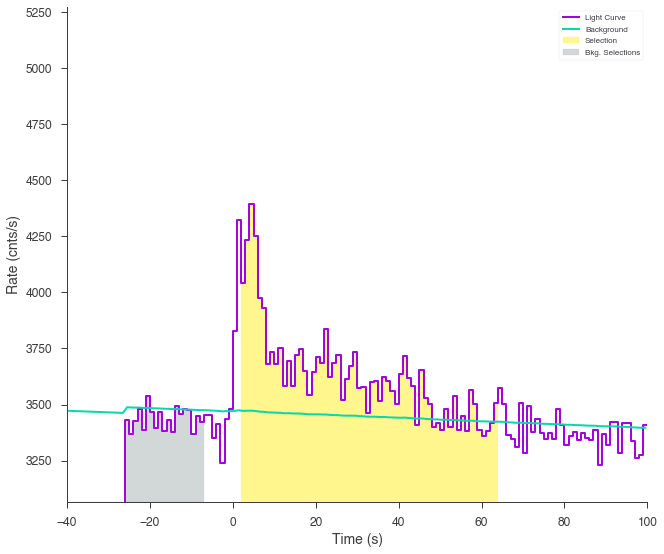

In [7]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    
    
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )
    
    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)
    
    fluence_plugin = ts_tte.to_spectrumlike()
    
    if det.startswith("b"):
        
        fluence_plugin.set_active_measurements("250-30000")
    
    else:
        
        fluence_plugin.set_active_measurements("9-900")
    
    fluence_plugin.rebin_on_background(1.)
    
    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog. 

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters. 


In [8]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(lower_bound = -1.5, upper_bound = 1, mu=-1, sigma=0.5)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(lower_bound = -5, upper_bound = -1.6, mu=-2.25, sigma=0.5)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(lower_bound = 1E-3, upper_bound = 1E1)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(lower_bound = 1E-4, upper_bound = 10)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest. 

In [9]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))
bayes.set_sampler("multinest")


### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.  

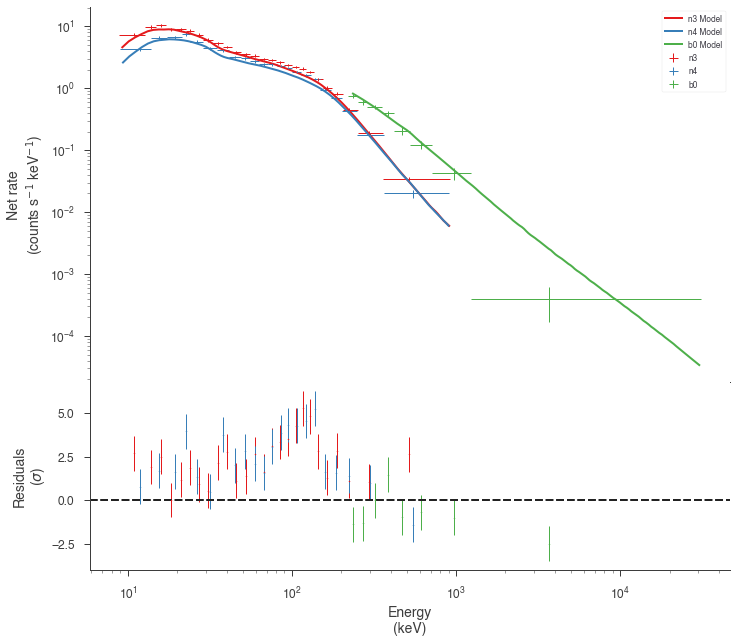

In [10]:
display_spectrum_model_counts(bayes, min_rate=20, step=False );

### Run the sampler
We let MultiNest condition the model on the data

In [11]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
GRB080916009...K,(1.467 +/- 0.019) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.070 -0.018 +0.019,
GRB080916009...break_energy,(2.38 -0.31 +0.32) x 10^2,keV
GRB080916009...break_scale,(2.4 +/- 0.8) x 10^-1,
GRB080916009...beta,-2.22 +/- 0.12,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0,-1072.839051
n3,-1023.565801
n4,-1014.475396
total,-3110.880247



Values of statistical measures:



,statistical measures
AIC,6231.930949
BIC,6251.163160
DIC,6218.937608
PDIC,4.569022
log(Z),-1356.935237


Now our model seems to match much better with the data! 

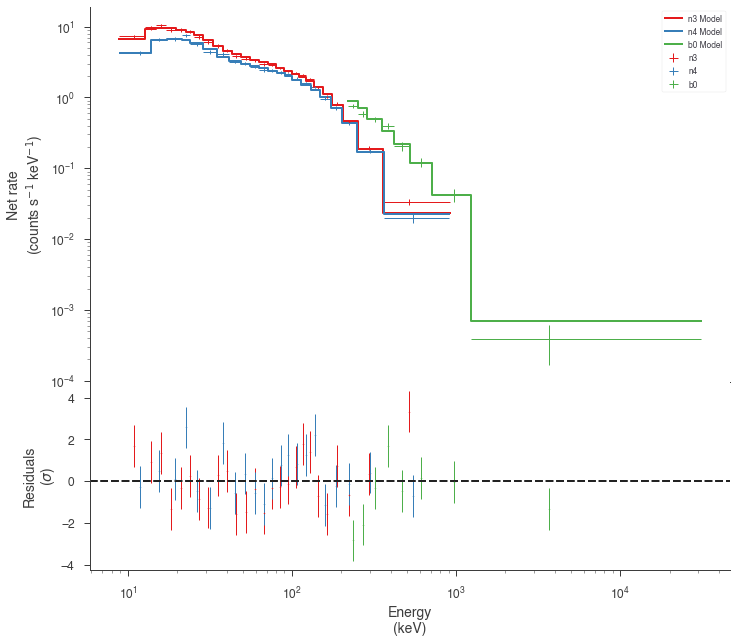

In [12]:
bayes.restore_median_fit()
display_spectrum_model_counts(bayes, min_rate=20);

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [13]:
conversion = u.Unit('keV2/(cm2 s keV)').to('erg2/(cm2 s keV)')
energy_grid = np.logspace(1,4, 100)*u.keV
vFv = (energy_grid**2* model.get_point_source_fluxes(0, energy_grid)).to('erg2/(cm2 s keV)')



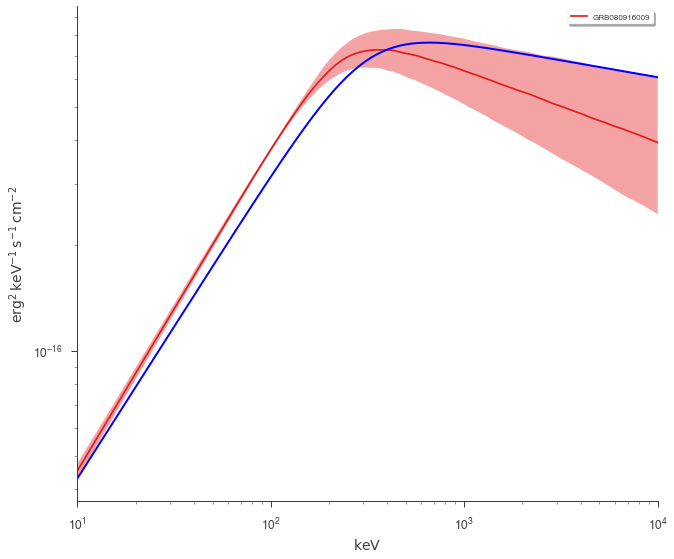

In [14]:
fig = plot_point_source_spectra(bayes.results, flux_unit='erg2/(cm2 s keV)');
ax = fig.get_axes()[0]
ax.loglog(energy_grid, vFv, color='blue', label='catalog model')

## Time Resolved Analysis 

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [15]:
n3 = time_series['n3']

In [16]:
n3.create_time_bins(0,60, method="bayesblocks", use_background=True, p0=0.2)

Created 15 bins via bayesblocks


Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

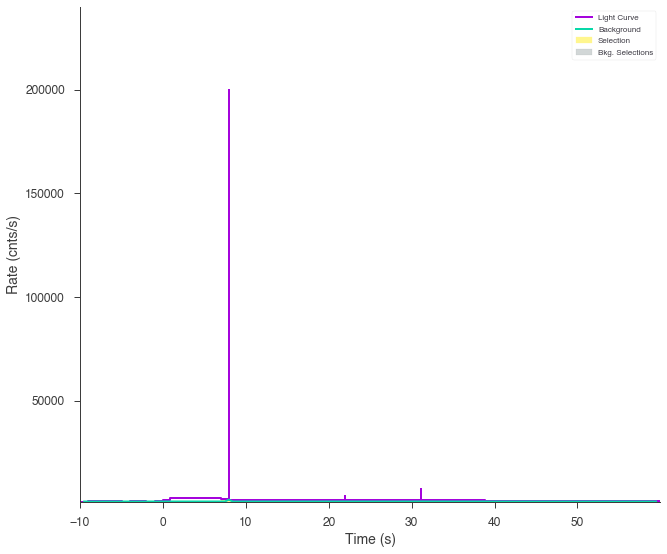

In [17]:
n3.view_lightcurve(use_binner=True);

In [18]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):
    
    if w < 5E-2:
        bad_bins.append(i)
    
    
edges = [n3.bins.starts[0]]

for i,b in enumerate(n3.bins):
    
    if i not in bad_bins:        
        edges.append(b.stop)

starts=edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method='custom')

Created 12 bins via custom


Now our light curve looks much more acceptable.

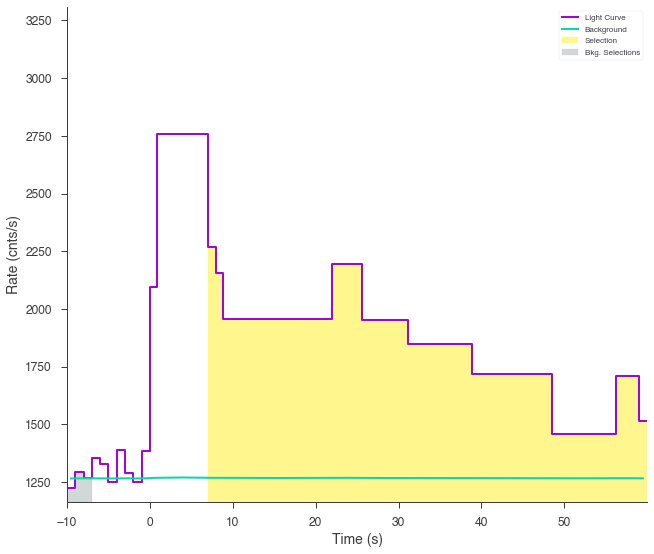

In [19]:
n3.view_lightcurve(use_binner=True);

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above. 

In [20]:
time_resolved_plugins = {}

for k,v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

Created 12 bins via custom


Created 12 bins via custom


Created 12 bins via custom


### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [21]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound = -1.5, upper_bound = 1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound = -5, upper_bound = -1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1E-10, upper_bound=1E3)
ps = PointSource('grb', 0,0, spectral_shape=band)
band_model = Model(ps)



### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [22]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)
    bayes.set_sampler("multinest")
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.4 +/- 0.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.9 -0.9 +1.0) x 10^-1,
grb.spectrum.main.Band.xp,(3.5 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.52 -0.20 +0.21,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval0,-284.092132
n3_interval0,-245.197184
n4_interval0,-262.694890
total,-791.984205



Values of statistical measures:



,statistical measures
AIC,1592.081725
BIC,1607.490543
DIC,1569.554646
PDIC,2.260288
log(Z),-345.419228


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(7.51 -0.18 +0.28) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-4.85 -0.22 +0.28) x 10^-1,
grb.spectrum.main.Band.xp,(2.376 -0.04 +0.031) x 10^2,keV
grb.spectrum.main.Band.beta,-1.824 -0.010 +0.013,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval1,-699.207775
n3_interval1,-660.320455
n4_interval1,-650.387351
total,-2009.915581



Values of statistical measures:



,statistical measures
AIC,4027.944477
BIC,4043.353295
DIC,4006.031674
PDIC,1.310157
log(Z),-879.876570


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.92 -0.18 +0.19) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.00 -0.05 +0.04,
grb.spectrum.main.Band.xp,(4.1 -0.8 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-1.84 -0.06 +0.05,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval2,-320.384149
n3_interval2,-282.657411
n4_interval2,-305.101494
total,-908.143053



Values of statistical measures:



,statistical measures
AIC,1824.399421
BIC,1839.808238
DIC,1800.887321
PDIC,1.397316
log(Z),-396.942679


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.10 -0.34 +0.33) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.7 +/- 0.8) x 10^-1,
grb.spectrum.main.Band.xp,(3.2 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.43 +/- 0.30,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval3,-296.371175
n3_interval3,-237.332047
n4_interval3,-257.446049
total,-791.149270



Values of statistical measures:



,statistical measures
AIC,1590.411855
BIC,1605.820672
DIC,1568.567198
PDIC,2.532479
log(Z),-344.900925


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.10 +/- 0.09) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.62 -0.33 +0.32) x 10^-1,
grb.spectrum.main.Band.xp,(3.80 +/- 0.35) x 10^2,keV
grb.spectrum.main.Band.beta,-2.03 +/- 0.08,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval4,-791.645837
n3_interval4,-751.711638
n4_interval4,-741.102354
total,-2284.459829



Values of statistical measures:



,statistical measures
AIC,4577.032972
BIC,4592.441790
DIC,4555.696500
PDIC,2.847320
log(Z),-995.361705


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.91 -0.20 +0.19) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.7 +/- 0.6) x 10^-1,
grb.spectrum.main.Band.xp,(3.9 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.13 +/- 0.10,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval5,-541.990810
n3_interval5,-517.746571
n4_interval5,-521.703151
total,-1581.440533



Values of statistical measures:



,statistical measures
AIC,3170.994380
BIC,3186.403197
DIC,3149.682069
PDIC,3.257779
log(Z),-689.244839


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.03 -0.13 +0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.9 +/- 0.5) x 10^-1,
grb.spectrum.main.Band.xp,(4.1 -0.5 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-2.56 -0.30 +0.33,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval6,-611.476875
n3_interval6,-578.625631
n4_interval6,-571.172859
total,-1761.275365



Values of statistical measures:



,statistical measures
AIC,3530.664045
BIC,3546.072862
DIC,3507.174576
PDIC,2.995084
log(Z),-766.890825


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.70 +/- 0.10) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.03 +/- 0.04,
grb.spectrum.main.Band.xp,(4.1 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.44 +/- 0.23,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval7,-670.570443
n3_interval7,-635.279771
n4_interval7,-644.799724
total,-1950.649937



Values of statistical measures:



,statistical measures
AIC,3909.413188
BIC,3924.822006
DIC,3886.444842
PDIC,2.968040
log(Z),-849.257030


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.58 +/- 0.13) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.2 +/- 0.6) x 10^-1,
grb.spectrum.main.Band.xp,(3.6 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.57 -0.26 +0.27,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval8,-705.657496
n3_interval8,-693.385305
n4_interval8,-661.074788
total,-2060.117589



Values of statistical measures:



,statistical measures
AIC,4128.348492
BIC,4143.757309
DIC,4107.633785
PDIC,3.139963
log(Z),-896.859354


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.44 -0.7 +0.35) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.4 -2.3 +2.1) x 10^-1,
grb.spectrum.main.Band.xp,(1.2 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.08 +/- 0.26,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval9,-654.621119
n3_interval9,-615.132418
n4_interval9,-614.107855
total,-1883.861392



Values of statistical measures:



,statistical measures
AIC,3775.836098
BIC,3791.244915
DIC,3720.126202
PDIC,-41.553714
log(Z),-820.551581


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.3 +/- 0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-6.8 +/- 1.3) x 10^-1,
grb.spectrum.main.Band.xp,(2.1 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.03 +/- 0.14,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval10,-461.313070
n3_interval10,-433.623206
n4_interval10,-429.319522
total,-1324.255798



Values of statistical measures:



,statistical measures
AIC,2656.624911
BIC,2672.033728
DIC,2637.793545
PDIC,0.974562
log(Z),-577.201475


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.3 +/- 1.2) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-4.3 -2.2 +2.3) x 10^-1,
grb.spectrum.main.Band.xp,(1.30 -0.26 +0.27) x 10^2,keV
grb.spectrum.main.Band.beta,-2.30 -0.32 +0.34,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval11,-291.851821
n3_interval11,-269.097236
n4_interval11,-252.570233
total,-813.519291



Values of statistical measures:



,statistical measures
AIC,1635.151896
BIC,1650.560713
DIC,1618.236530
PDIC,1.154841
log(Z),-354.525939


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

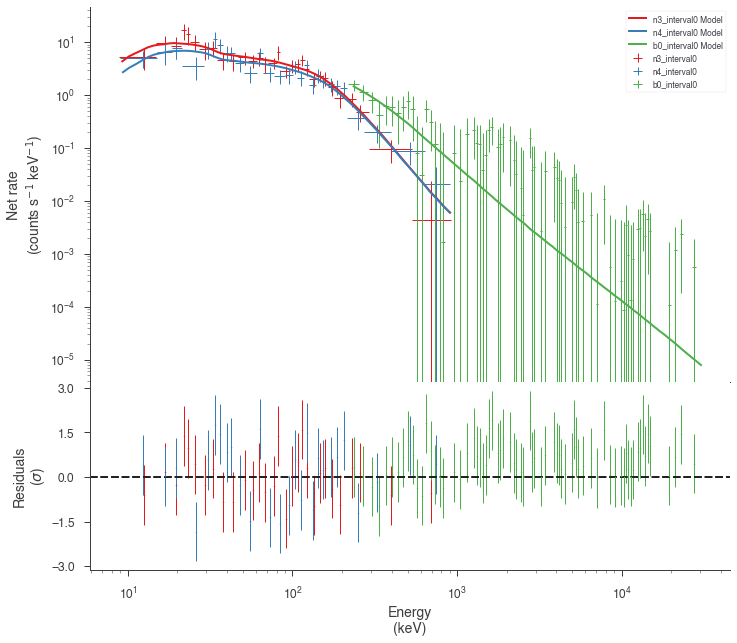

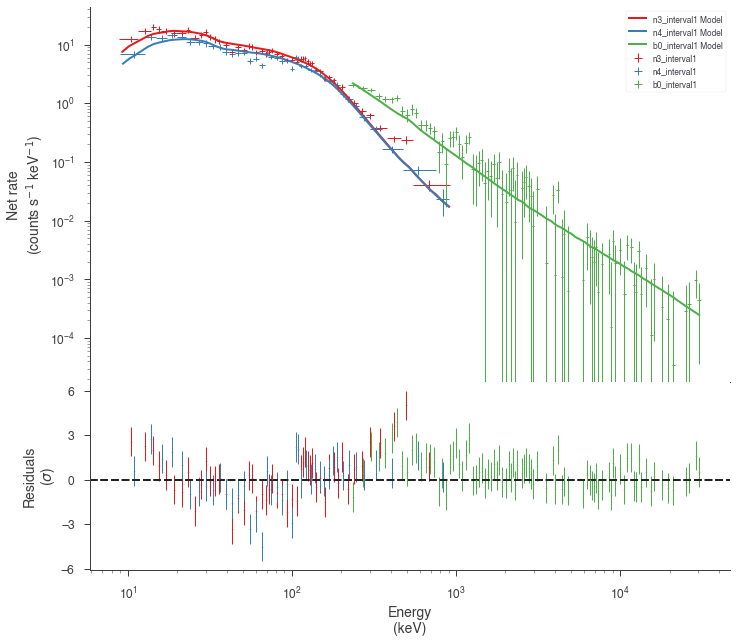

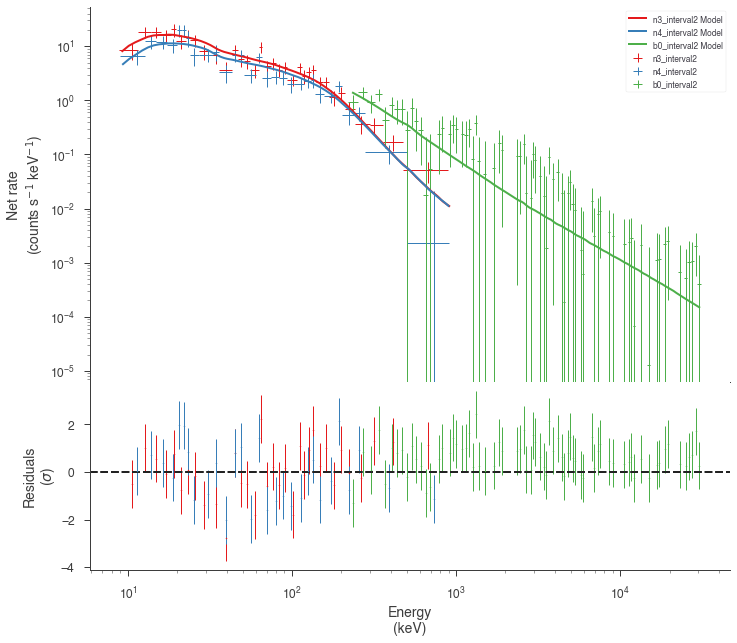

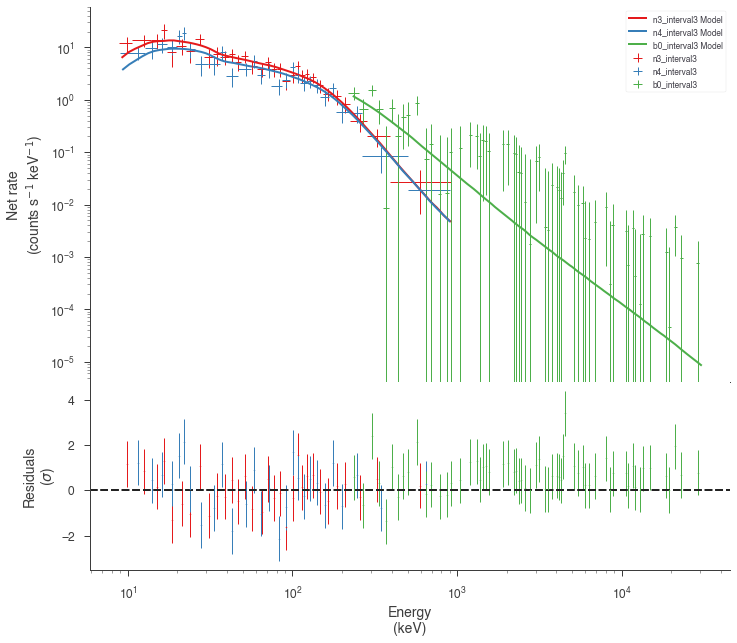

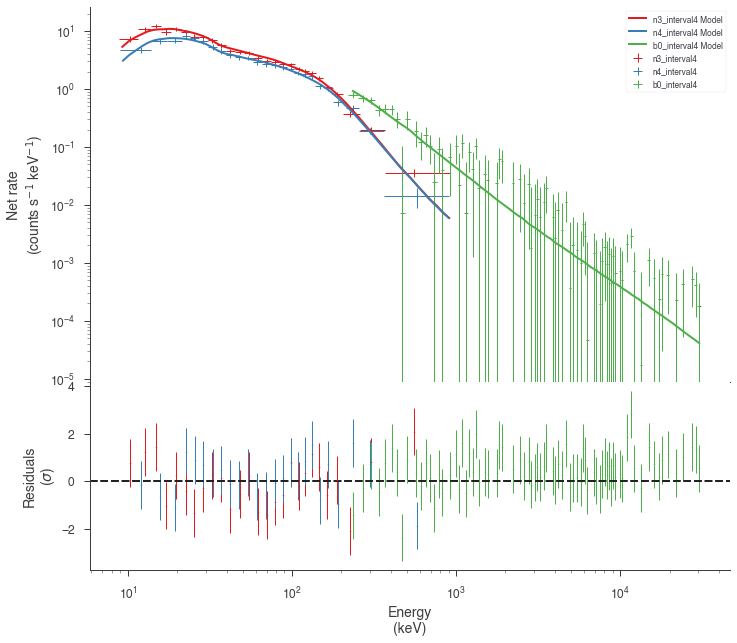

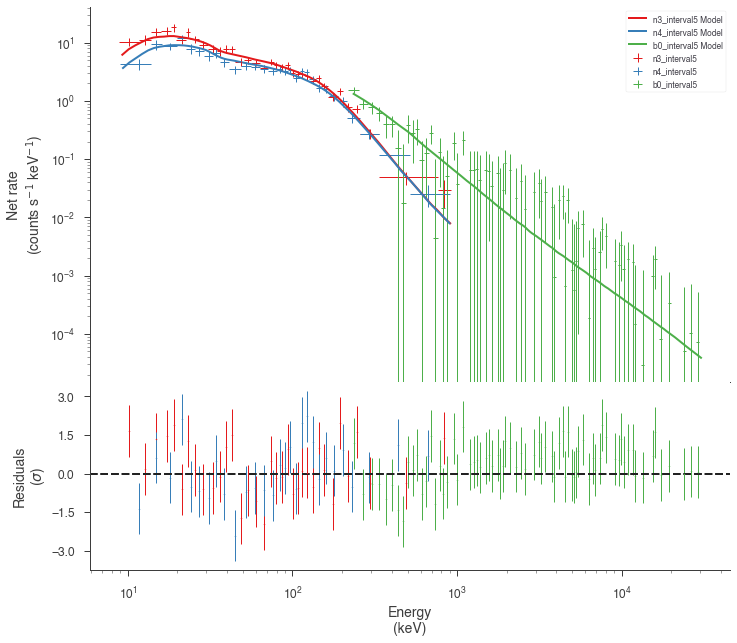

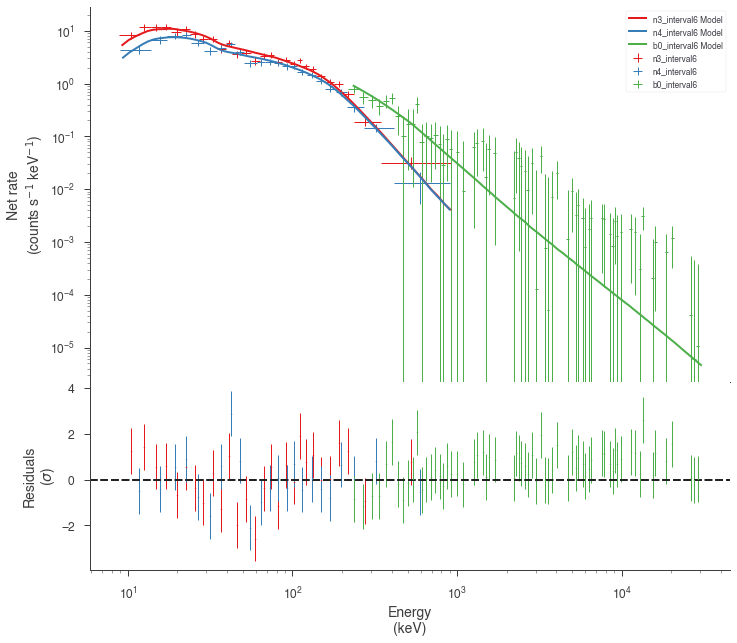

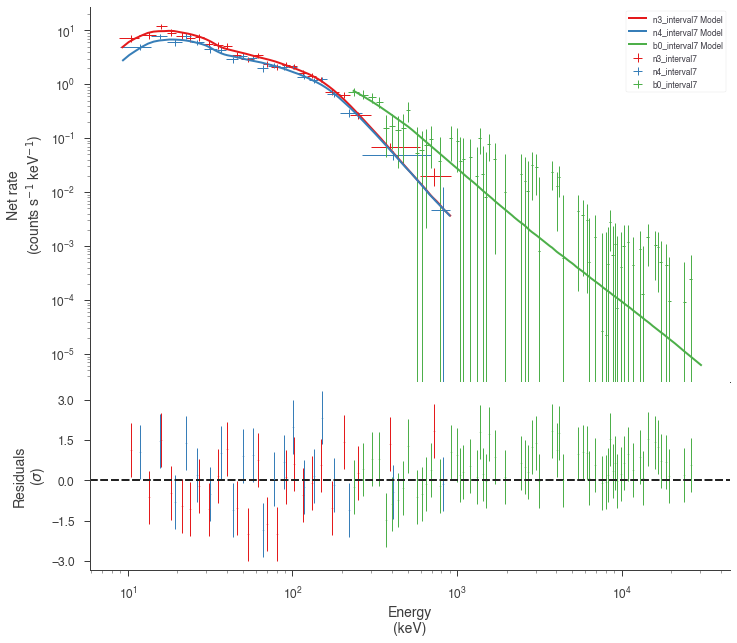

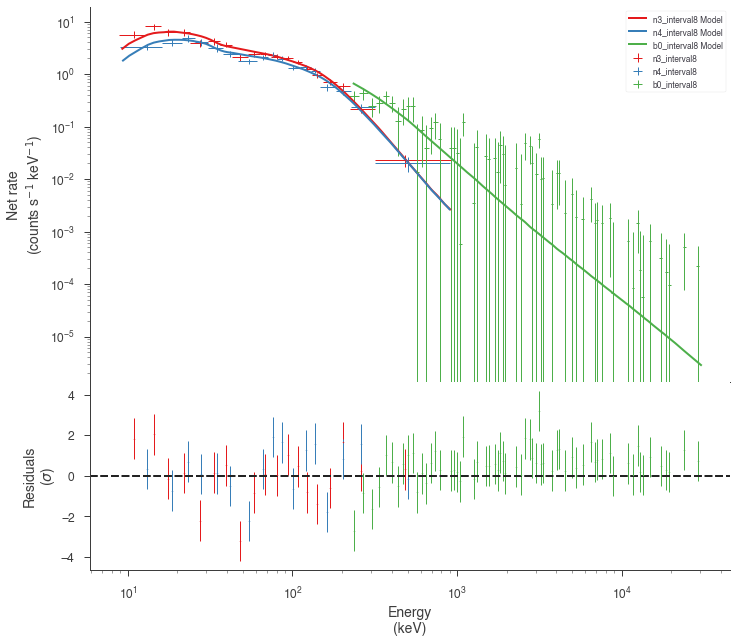

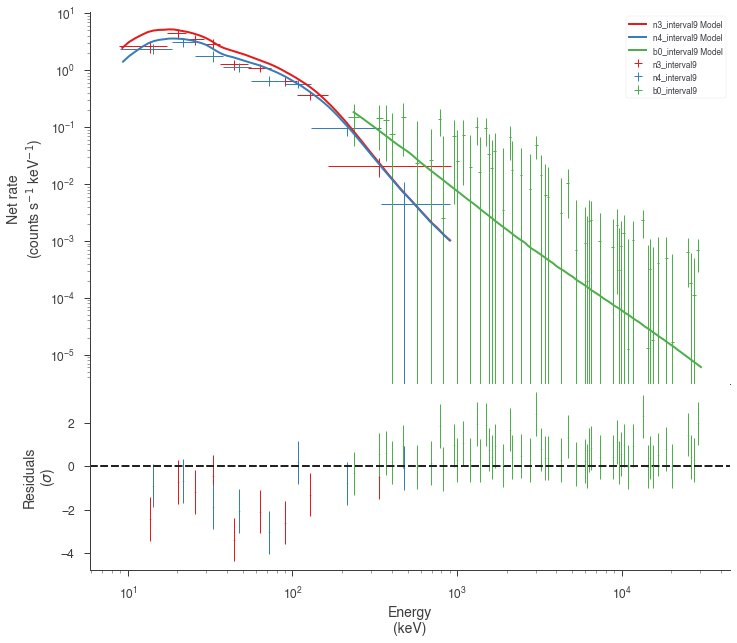

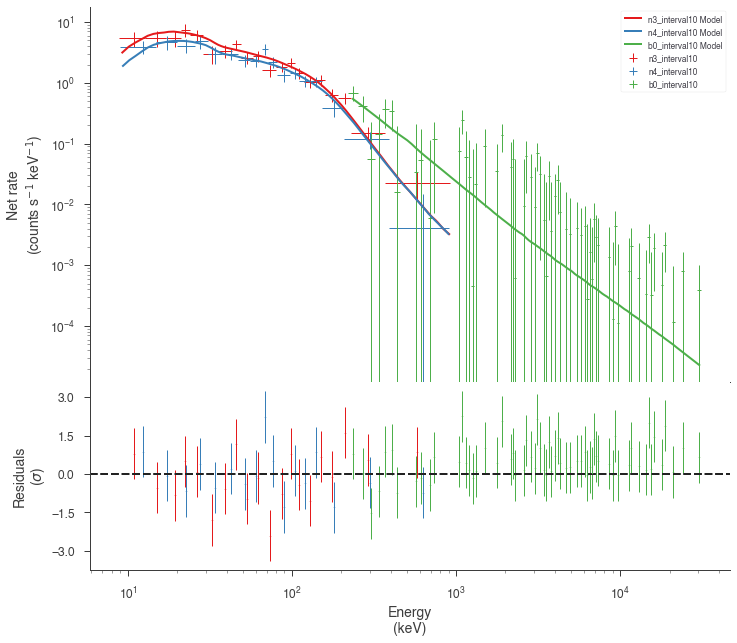

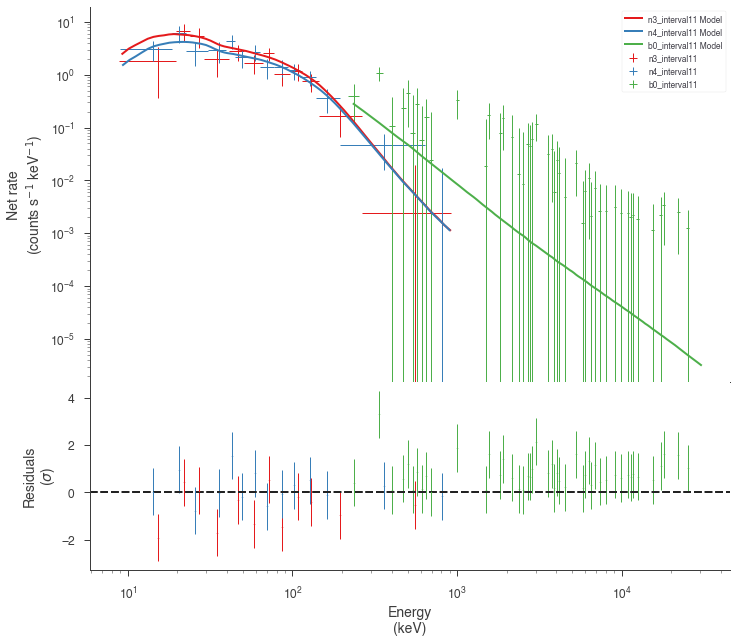

In [23]:
for a in analysis:
    a.restore_median_fit()
    display_spectrum_model_counts(a, min_rate=[20,20,-99], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

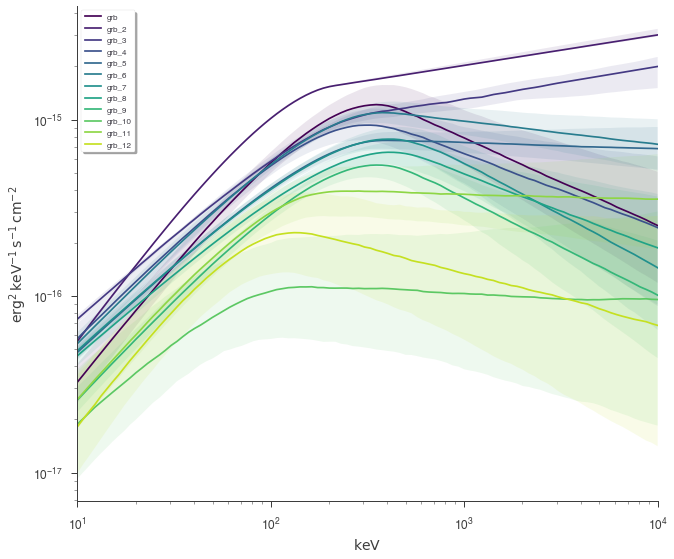

In [24]:
plot_spectra(*[a.results for a in analysis[::1]], flux_unit="erg2/(cm2 s keV)", fit_cmap='viridis', contour_cmap='viridis', contour_style_kwargs=dict(alpha=0.1));

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data. 